In [2]:
#Imports and configuration block

import numpy as np
import matplotlib.pyplot as plt
from infinite_env import BlackjackInfiniteEnv
from agent import BlackjackAgent

#Parameter confuration:
num_episodes=900000
alpha=0.01
gamma=0.9
epsilon=1.0
epsilon_decay=0.999995
min_epsilon=0.005

#Initialize environment and agent
env = BlackjackInfiniteEnv(seed=42)
agent = BlackjackAgent(alpha=alpha, gamma=gamma, epsilon=epsilon, 
                       epsilon_decay=epsilon_decay, min_epsilon=min_epsilon)

stats = {"rewards": [], "epsilon": [], "moving_avg": []}

In [3]:
#Training loop 

print(f"Starting training for {num_episodes} episodes...")

for i in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

    agent.decay_epsilon()
    stats["rewards"].append(episode_reward)
    stats["epsilon"].append(agent.epsilon)

    if (i + 1) % 1000 == 0:
        avg_r = np.mean(stats["rewards"][-1000:])
        stats["moving_avg"].append(avg_r)
        
    if (i + 1) % 100000 == 0:
        print(f"Episode {i+1}/{num_episodes} | Avg Reward: {avg_r:.2f} | Epsilon: {agent.epsilon:.4f}")

Starting training for 900000 episodes...
Episode 100000/900000 | Avg Reward: 164.67 | Epsilon: 0.6065
Episode 200000/900000 | Avg Reward: 212.13 | Epsilon: 0.3679
Episode 300000/900000 | Avg Reward: 237.83 | Epsilon: 0.2231
Episode 400000/900000 | Avg Reward: 252.13 | Epsilon: 0.1353
Episode 500000/900000 | Avg Reward: 264.42 | Epsilon: 0.0821
Episode 600000/900000 | Avg Reward: 272.64 | Epsilon: 0.0498
Episode 700000/900000 | Avg Reward: 276.66 | Epsilon: 0.0302
Episode 800000/900000 | Avg Reward: 278.40 | Epsilon: 0.0183
Episode 900000/900000 | Avg Reward: 276.19 | Epsilon: 0.0111


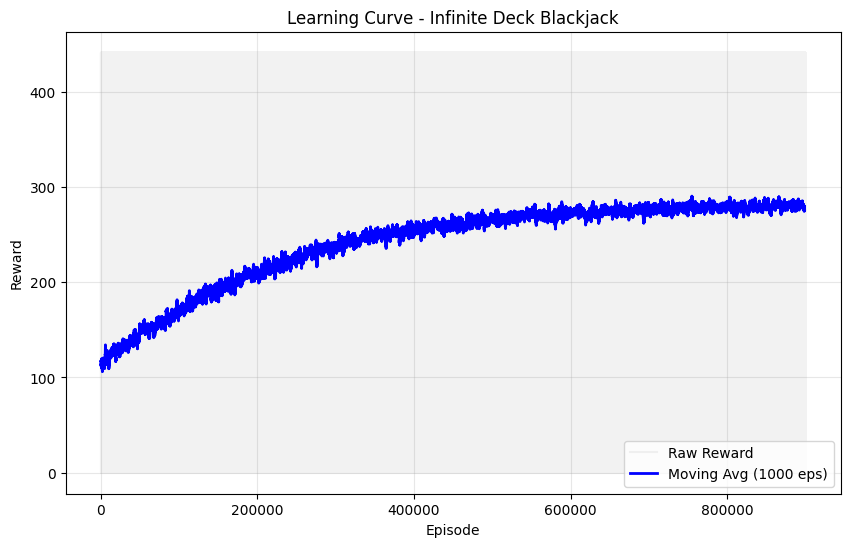

In [4]:
# Plotting function

def moving_average(data, window_size=1000):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(stats["rewards"], alpha=0.1, color='gray', label='Raw Reward')
plt.plot(moving_average(stats["rewards"]), color='blue', linewidth=2, label='Moving Avg (1000 eps)')
plt.title('Learning Curve - Infinite Deck Blackjack')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Performance evaluation vs baseline strategy
n_eval_episodes = 50000
eval_stats = {"ai_scores": [], "baseline_scores": [], "ai_busts": 0, "total_hands": 0}

# Guardamos epsilon para restaurarlo luego
original_eps = agent.epsilon
agent.epsilon = 0.0 # Evaluación determinista

for i in range(n_eval_episodes):
    # 1. EVALUAR IA
    state = env.reset()
    done = False
    score_ai = 0
    while not done:
        action = np.argmax(agent.q_table[state])
        state, reward, done, info = env.step(action)
        score_ai += reward
        if done and state[0] > 21: eval_stats["ai_busts"] += 1
    eval_stats["ai_scores"].append(score_ai)

    # 2. EVALUAR BASELINE (Lógica: Hit if < 17)
    state = env.reset()
    done = False
    score_base = 0
    while not done:
        action = 1 if state[0] < 17 else 0
        state, reward, done, _ = env.step(action)
        score_base += reward
    eval_stats["baseline_scores"].append(score_base)

agent.epsilon = original_eps # Restaurar

# Resultados
print(f"--- Evaluation results ({n_eval_episodes} episodios) ---")
print(f"Trained Agent Average:       {np.mean(eval_stats['ai_scores']):.4f}")
print(f"Baseline Average: {np.mean(eval_stats['baseline_scores']):.4f}")
print(f"Bust Rate:      {(eval_stats['ai_busts']/n_eval_episodes)*100:.2f}%")

--- Evaluation results (50000 episodios) ---
Trained Agent Average:       282.1760
Baseline Average: 261.4259
Bust Rate:      3.35%


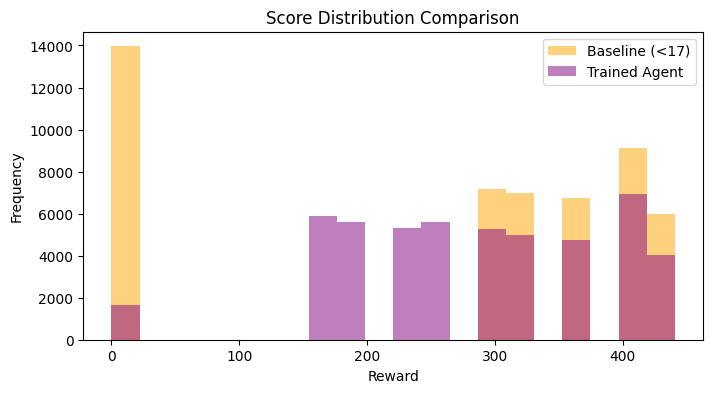

In [10]:
#Score distributions and strategy comparison

# Comparative histograms
plt.figure(figsize=(8, 4))
plt.hist(eval_stats["baseline_scores"], bins=20, alpha=0.5, label='Baseline (<17)', color='orange')
plt.hist(eval_stats["ai_scores"], bins=20, alpha=0.5, label='Trained Agent', color='purple')
plt.title("Score Distribution Comparison")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [35]:
# Comparison of Decision Making: Baseline vs. Trained Agent
print("\n" + "="*65)
print("STRATEGY COMPARISON: BASELINE VS. TRAINED AGENT")
print("="*65)
print(f"{'Sum':<6} | {'Baseline':<12} | {'AI (No Ace)':<15} | {'AI (With Ace)':<15}")
print("-" * 65)

# Ensure we are using the correct agent object
# If your train_infinite returned a tuple, we take the first element
if isinstance(trained_agent, tuple):
    agent_obj = trained_agent[0]
else:
    agent_obj = trained_agent

for s in range(11, 22):
    # Fixed Baseline Logic: Hit if < 17
    base_act = "HIT" if s < 17 else "STICK"
    
    # AI Decisions from Q-Table
    # We use agent_obj.q_table to access the dictionary
    ia_no_ace = "STICK" if np.argmax(agent_obj.q_table[(s, False)]) == 0 else "HIT"
    ia_ace = "STICK" if np.argmax(agent_obj.q_table[(s, True)]) == 0 else "HIT"
    
    # Mark states where AI deviates from the simple rule
    diff_mark = "(!)" if (ia_no_ace != base_act or ia_ace != base_act) else ""
    
    print(f" {s:<5} | {base_act:<12} | {ia_no_ace:<15} | {ia_ace:<15} {diff_mark}")

print("="*65)
print("(!) Indicates states where the agent learned a more nuanced strategy.")

print(f"Agent wins in total: {np.sum(eval_stats['ai_scores'])}")
print(f"Baseline wins in total: {np.sum(eval_stats['baseline_scores'])}")


STRATEGY COMPARISON: BASELINE VS. TRAINED AGENT
Sum    | Baseline     | AI (No Ace)     | AI (With Ace)  
-----------------------------------------------------------------
 11    | HIT          | HIT             | HIT             
 12    | HIT          | HIT             | HIT             
 13    | HIT          | STICK           | HIT             (!)
 14    | HIT          | STICK           | HIT             (!)
 15    | HIT          | STICK           | HIT             (!)
 16    | HIT          | STICK           | STICK           (!)
 17    | STICK        | STICK           | STICK           
 18    | STICK        | STICK           | STICK           
 19    | STICK        | STICK           | STICK           
 20    | STICK        | STICK           | STICK           
 21    | STICK        | STICK           | STICK           
(!) Indicates states where the agent learned a more nuanced strategy.
Agent wins in total: 14127736
Baseline wins in total: 13002270
